# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
num_folds = 5
X_train_folds = np.array_split(X_train_feats, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

for lr in learning_rates:
    for reg in regularization_strengths:
        accuracies_train = []
        accuracies_test = []
        for f in range(num_folds):
            Xte = X_train_folds[f]
            Xtr = np.concatenate([X_train_folds[i] for i in range(5) if i != f])
            yte = y_train_folds[f]
            ytr = np.concatenate([y_train_folds[i] for i in range(5) if i != f])
            svm = LinearSVM()
            svm.train(Xtr, ytr, learning_rate=lr, reg=reg,
                      num_iters=100, verbose=False)
            ytr_pred = svm.predict(Xtr)
            yte_pred = svm.predict(Xte)
            accuracies_train.append(np.mean(ytr_pred == ytr))
            accuracies_test.append(np.mean(yte_pred == yte))
                              
        results[(lr, reg)] = (np.mean(accuracies_train), np.mean(accuracies_test))
        
lr, reg = max(results, key=results.get)
best_svm = LinearSVM()
_ = best_svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
y_val_pred = best_svm.predict(X_val_feats)
best_val = np.mean(y_val == y_val_pred)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 754.108882
iteration 100 / 1500: loss 8.999968
iteration 200 / 1500: loss 8.999965
iteration 300 / 1500: loss 8.999973
iteration 400 / 1500: loss 8.999966
iteration 500 / 1500: loss 8.999972
iteration 600 / 1500: loss 8.999970
iteration 700 / 1500: loss 8.999966
iteration 800 / 1500: loss 8.999965
iteration 900 / 1500: loss 8.999975
iteration 1000 / 1500: loss 8.999965
iteration 1100 / 1500: loss 8.999969
iteration 1200 / 1500: loss 8.999960
iteration 1300 / 1500: loss 8.999973
iteration 1400 / 1500: loss 8.999965
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.100791 val accuracy: 0.099857
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.105903 val accuracy: 0.108449
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.096980 val accuracy: 0.094959
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.089388 val accuracy: 0.089980
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.110628 val accuracy: 0.110265
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.413


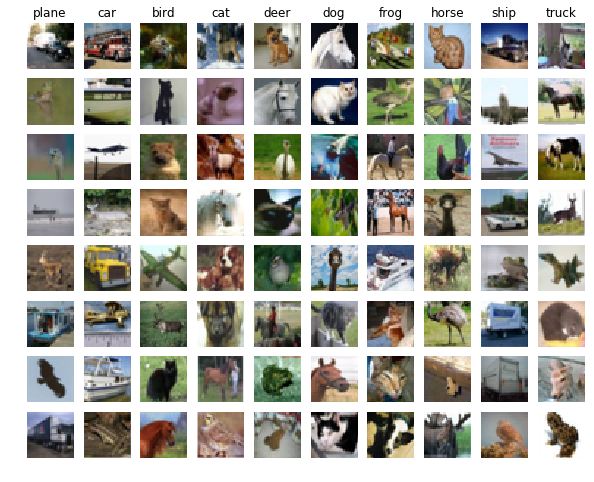

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?  

Truck missclassifications have sharp linear gradient edges, planes have blue at the top of them, birds are basically small object on blurry background - they all can be descibed like this in hog dimention 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print(X_train_feats.shape)

# Plot the loss function and train / validation accuracies
import matplotlib.gridspec as gridspec

def plot_stats(stats, outer_it, fig):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                subplot_spec=outer_it, wspace=0.1, hspace=0.3)
    ax = plt.Subplot(fig, inner[0])
    ax.plot(stats['loss_history'])
    ax.set_title('Loss history')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    legend = '\n'.join(sorted(['{}: {}'.format(par, val) for par, val in stats['params'].items()]))
    ax.legend([legend], loc=3)
    fig.add_subplot(ax)

    ax = plt.Subplot(fig, inner[1])
    ax.plot(stats['train_acc_history'], label='train')
    ax.plot(stats['val_acc_history'], label='val')
    ax.set_title('Classification accuracy history')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Clasification accuracy')
    ax.legend(['train', 'val'])
    fig.add_subplot(ax)
    
def stats_report(stats_lst, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10.0, 8.0))
    outer = gridspec.GridSpec(1, len(stats_lst), wspace=0.2, hspace=0.2)
    for stats, o in zip(stats_lst, outer):
        plot_stats(stats, o, fig)
    plt.show()

(49000, 155)


hidden_size: 600, learning_rate: 0.2782559402207123, reg: 0.01687593342019228, score: 0.502
hidden_size: 700, learning_rate: 3.593813663804626, reg: 0.0049215666011518475, score: 0.479
hidden_size: 500, learning_rate: 0.1, reg: 0.010631171876362321, score: 0.423
hidden_size: 700, learning_rate: 2.154434690031882, reg: 0.005741150360451557, score: 0.52
hidden_size: 700, learning_rate: 1.2915496650148828, reg: 0.01687593342019228, score: 0.509
hidden_size: 400, learning_rate: 1.2915496650148828, reg: 0.0026577929690905803, score: 0.579


/cs231n/assignment1/cs231n/classifiers/neural_net.py:12: RuntimeWarning: overflow encountered in exp
  exps = np.exp(x)
/cs231n/assignment1/cs231n/classifiers/neural_net.py:13: RuntimeWarning: invalid value encountered in true_divide
  return exps/np.expand_dims(exps.sum(axis=-1), axis=-1)
/cs231n/assignment1/cs231n/classifiers/neural_net.py:109: RuntimeWarning: divide by zero encountered in log
  loss = np.log(corect_class_score).sum()
/cs231n/assignment1/cs231n/classifiers/neural_net.py:132: RuntimeWarning: invalid value encountered in less_equal
  dH[hidden_in <= 0] = 0


hidden_size: 500, learning_rate: 10.0, reg: 0.014466792379488917, score: 0.105
hidden_size: 500, learning_rate: 0.2782559402207123, reg: 0.022964601441806228, score: 0.472
hidden_size: 500, learning_rate: 0.0027825594022071257, reg: 0.0031003926796253885, score: 0.113
hidden_size: 700, learning_rate: 0.007742636826811269, reg: 0.026788874464158525, score: 0.113
hidden_size: 600, learning_rate: 10.0, reg: 0.005741150360451557, score: 0.105
hidden_size: 500, learning_rate: 0.021544346900318832, reg: 0.0031003926796253885, score: 0.139
hidden_size: 700, learning_rate: 0.05994842503189409, reg: 0.0022783770304221013, score: 0.297
hidden_size: 400, learning_rate: 0.021544346900318832, reg: 0.00421898335504807, score: 0.14
hidden_size: 600, learning_rate: 5.994842503189409, reg: 0.0078125, score: 0.105
hidden_size: 400, learning_rate: 0.004641588833612777, reg: 0.0031003926796253885, score: 0.113
hidden_size: 600, learning_rate: 0.774263682681127, reg: 0.026788874464158525, score: 0.489
hidd

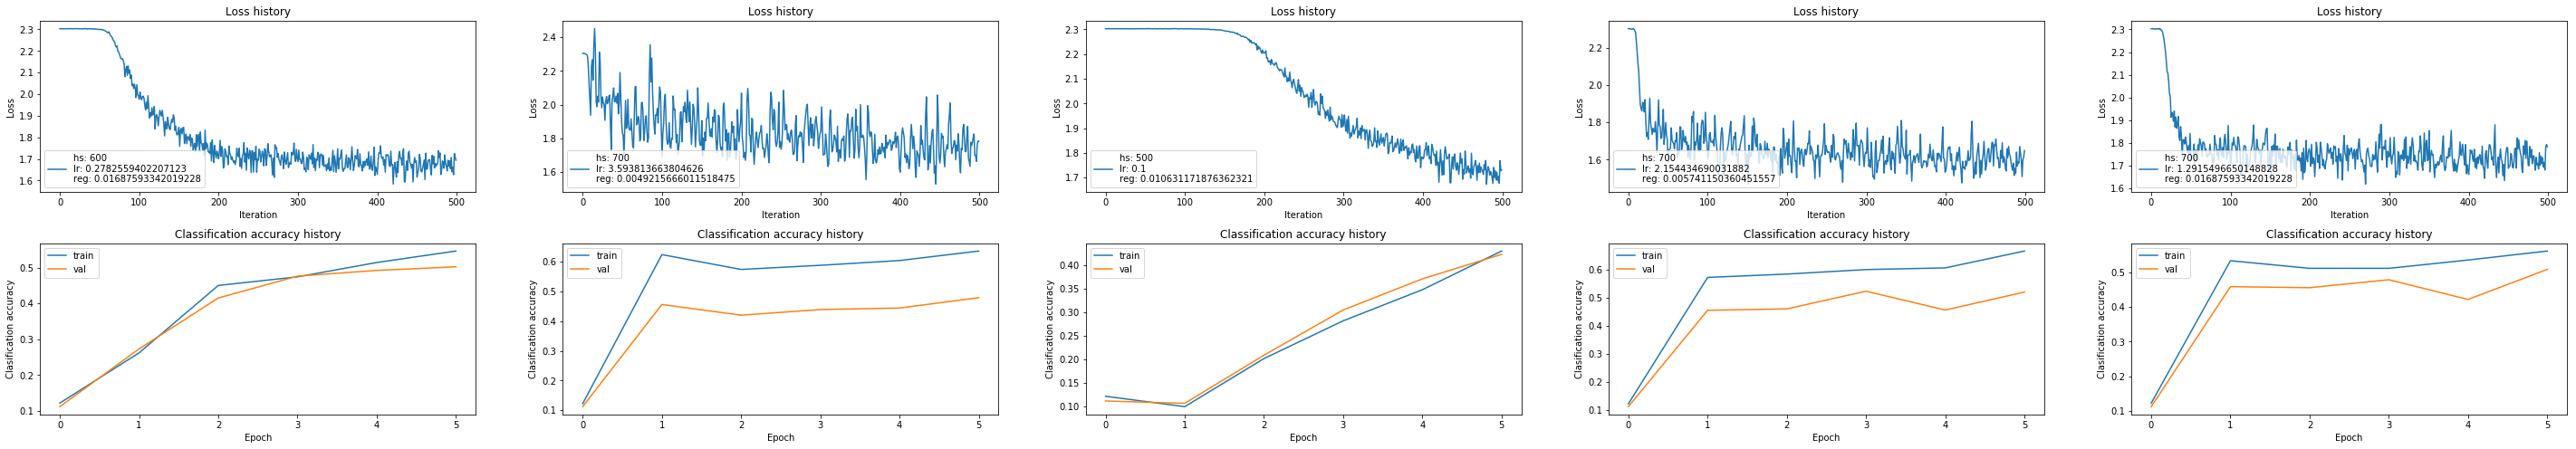

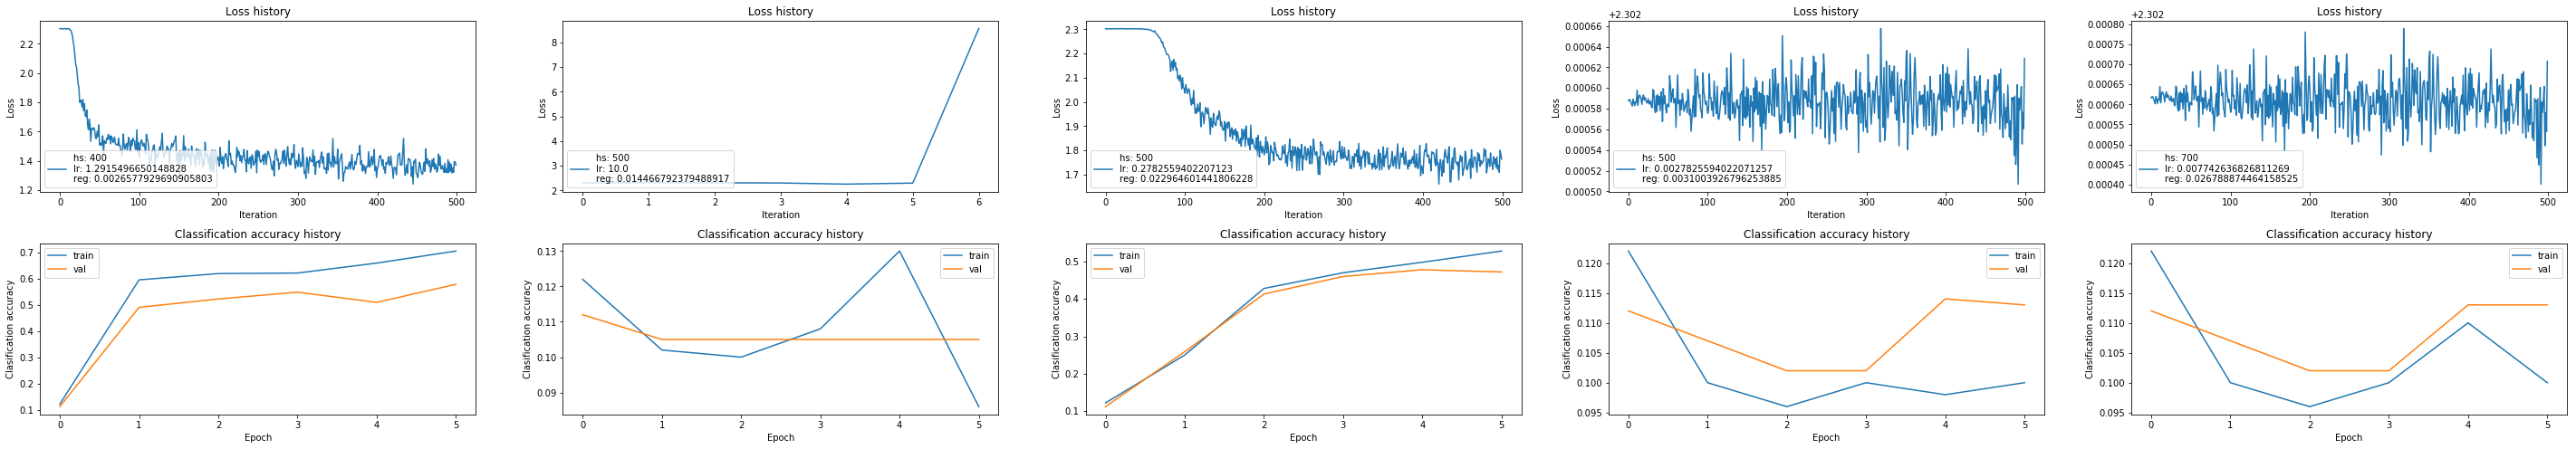

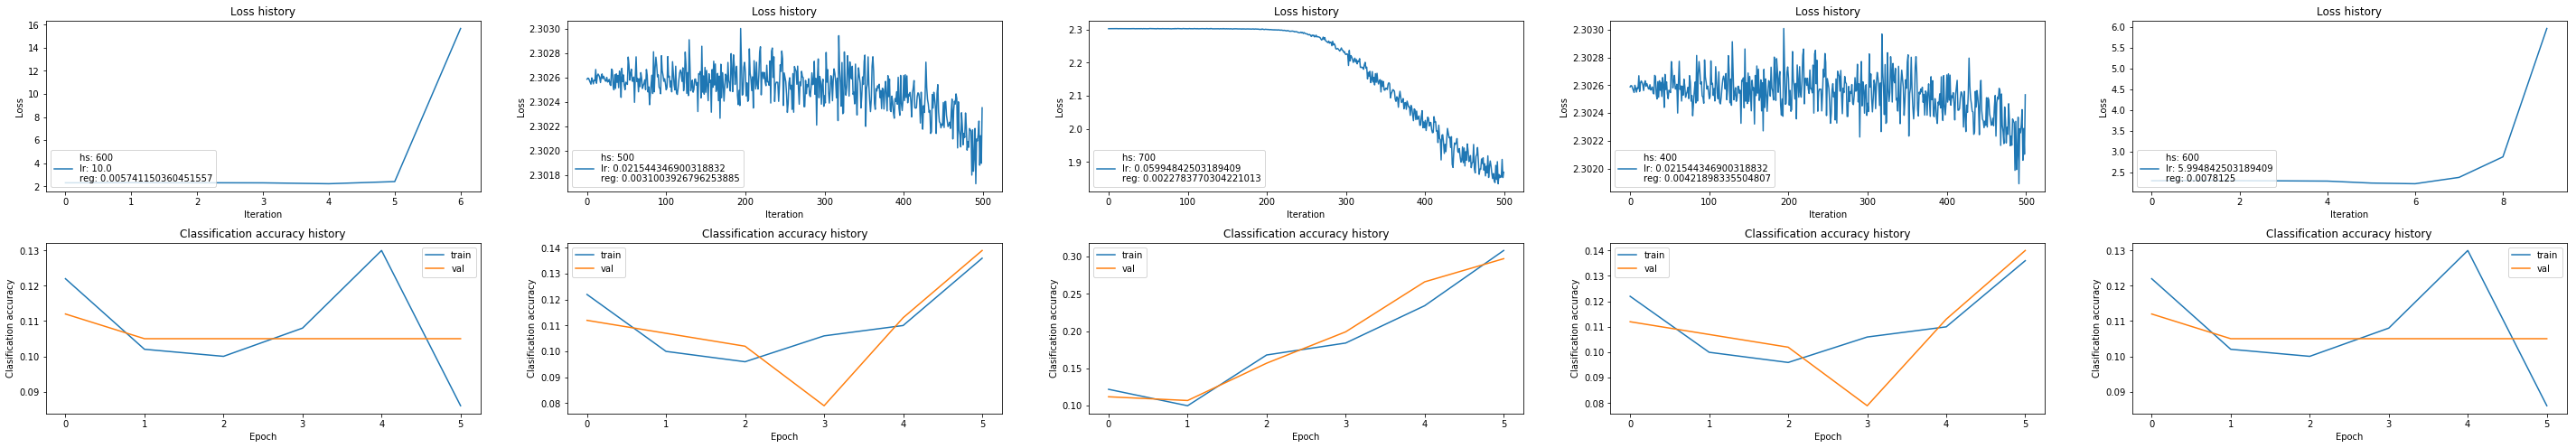

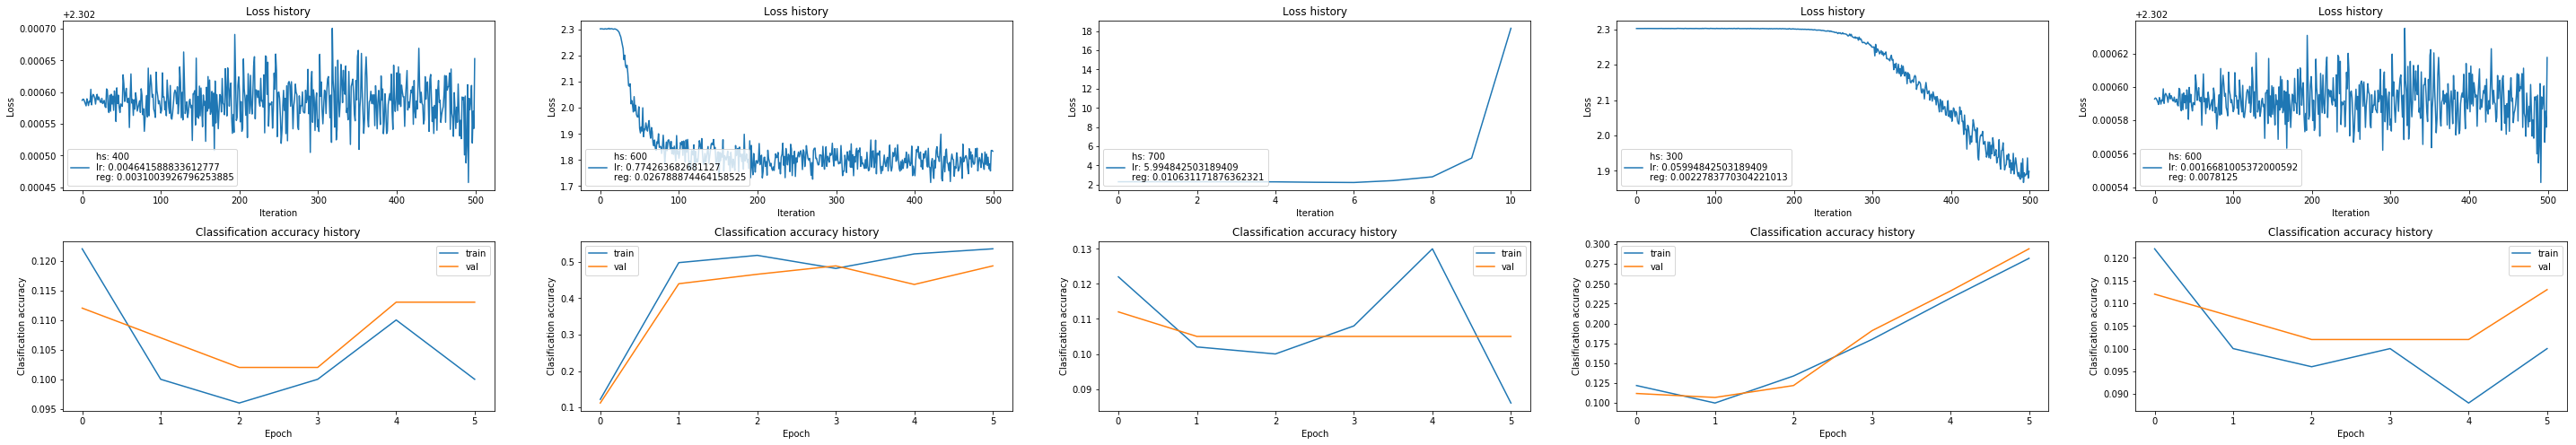

iteration 0 / 5000: loss 1.421010
iteration 100 / 5000: loss 1.327509
iteration 200 / 5000: loss 1.374445
iteration 300 / 5000: loss 1.329660
iteration 400 / 5000: loss 1.326977
iteration 500 / 5000: loss 1.396704
iteration 600 / 5000: loss 1.313411
iteration 700 / 5000: loss 1.364850
iteration 800 / 5000: loss 1.365317
iteration 900 / 5000: loss 1.277667
iteration 1000 / 5000: loss 1.401089
iteration 1100 / 5000: loss 1.309552
iteration 1200 / 5000: loss 1.333853
iteration 1300 / 5000: loss 1.189322
iteration 1400 / 5000: loss 1.312831
iteration 1500 / 5000: loss 1.237352
iteration 1600 / 5000: loss 1.233468
iteration 1700 / 5000: loss 1.318213
iteration 1800 / 5000: loss 1.224472
iteration 1900 / 5000: loss 1.265574
iteration 2000 / 5000: loss 1.232122
iteration 2100 / 5000: loss 1.268088
iteration 2200 / 5000: loss 1.301501
iteration 2300 / 5000: loss 1.296144
iteration 2400 / 5000: loss 1.209743
iteration 2500 / 5000: loss 1.286534
iteration 2600 / 5000: loss 1.240245
iteration 270

In [47]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
input_size = input_dim
hidden_size_set = np.array([300, 400, 500, 600, 700])
learning_rate_set = 10 ** np.linspace(-3, 1, 19)
reg_set = 2 ** np.linspace(-9, -5, 19)

# random search
num_trials = 20

best_score = -np.inf
rs = np.random.RandomState(42)
stats_lst = []
trials = zip(rs.choice(hidden_size_set, num_trials),
             rs.choice(learning_rate_set, num_trials),
             rs.choice(reg_set, num_trials))
for hidden_size, learning_rate, reg in trials:
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=500, batch_size=500,
                learning_rate=learning_rate, learning_rate_decay=0.95,
                reg=reg, verbose=False)
    stats['params'] = {'lr': learning_rate, 'reg': reg, 'hs': hidden_size}
    score = stats['val_acc_history'][-1]
    stats['val_score'] = score
    stats_lst.append(stats)
    print('hidden_size: {h}, learning_rate: {l}, reg: {r}, score: {s}'\
          .format(h=hidden_size, l=learning_rate, r=reg, s=score))
    if score > best_score:
        best_net = net
        best_score = score
        best_params = {'learning_rate': learning_rate, 'reg': reg}
        best_stats = stats
    
step = 5
for i in range(0, len(stats_lst), step):
    fig = plt.figure(figsize=(20.0, 8.0))
    stats_report(stats_lst[i:min([i+step, len(stats_lst)])], fig)

best_stats = best_net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=5000, batch_size=500,
                learning_rate_decay=0.95, verbose=True, 
               **best_params)
best_stats['params'] = best_params
best_stats['params']['hs'] = best_net.params['W1'].shape[1]
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

({'hs': 400,
  'learning_rate': 1.2915496650148828,
  'reg': 0.0026577929690905803},
 0.57899999999999996)

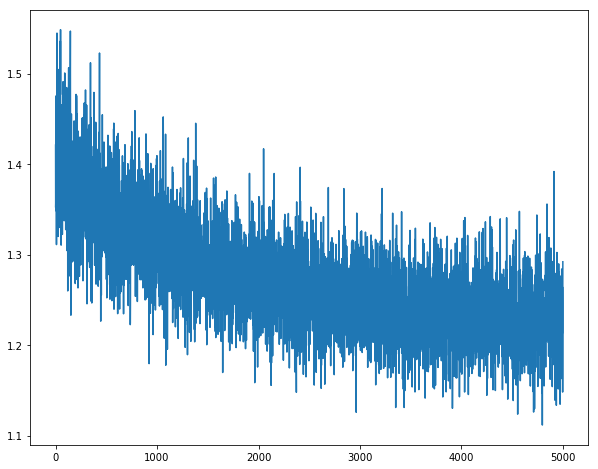

In [48]:
plt.plot(best_stats['loss_history'])
best_stats['params'], best_score

In [51]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.585


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!